In [2]:
#Optimum filter V1.1, adapt to the case where the trace length is longer than the template
import numpy as np
from numpy.fft import rfft, irfft, fft, ifft, fftfreq, rfftfreq
from scipy.signal import fftconvolve


class OptimumFilter():
    
    def __init__(self, template, noise_psd, sampling_frequency):
        self._template = template
        self._noise_psd = noise_psd
        self._sampling_frequency = sampling_frequency
        self._update_state()
        
    def set_template(self, template):
        self._template = template
        self._update_state()
        
    def set_noise_psd(self, noise_psd):
        self._noise_psd = noise_psd
        self._update_state()
        
    def _update_state(self):
        self._length = len(self._template)
        
        if self._length%2==0:
            self._noise_psd_unfolded = np.concatenate(([np.inf],
                                                       self._noise_psd[1:-1]/2,
                                                       [self._noise_psd[-1]],
                                                       self._noise_psd[-2:0:-1]/2))
        else:
            self._noise_psd_unfolded = np.concatenate(([np.inf],
                                                       self._noise_psd[1:]/2,
                                                       self._noise_psd[-1:0:-1]/2))
            
        self._template_fft = fft(self._template)/self._sampling_frequency
        
        self._kernel_fft = self._template_fft.conjugate() / self._noise_psd_unfolded
        self._kernel_normalization = np.real(np.dot(self._kernel_fft, self._template_fft))*self._sampling_frequency/self._length 
        self._filter_kernel = self._kernel_fft / self._kernel_normalization
        self._kernel_td = np.real(ifft(self._filter_kernel)) * self._sampling_frequency
        
        
    def fit(self, trace):
        trace_fft = fft(trace, axis=-1)/self._sampling_frequency # V
        trace_filtered = self._filter_kernel * trace_fft
        amp = np.real(trace_filtered.sum(axis=-1)) * self._sampling_frequency / self._length

        return amp
        #chisq0 = np.real((trace_fft.conj() * trace_fft / self._noise_psd_unfolded).sum()) * self._sampling_frequency / self._length
        #chisq = (chisq0 - amp**2 * self._kernel_normalization) / (self._length - 2) 
    
    def fit_with_shift(self, trace, allowed_shift_range=None):
 
        trace_fft = fft(trace, axis=-1)/self._sampling_frequency # V
        trace_filtered = self._filter_kernel * trace_fft
        trace_filtered_td = np.real(
            ifft(trace_filtered, axis=-1)
        ) * self._sampling_frequency

        chi0 = np.real((trace_fft.conj() * trace_fft / self._noise_psd_unfolded).sum()) * self._sampling_frequency / self._length
        chit_withdelay = (trace_filtered_td ** 2) * self._kernel_normalization
        chi = chi0 - chit_withdelay
        
        if allowed_shift_range is None:
            ind = np.arange(len(chi))
        else:
            ind = np.concatenate((np.arange(self._length+allowed_shift_range[0], self._length),
                                  np.arange(allowed_shift_range[1]+1)))
        
        best_ind = ind[np.argmin(chi[ind], axis=-1)]
        
        amp = trace_filtered_td[best_ind]
        chisq = chi[best_ind]/(self._length-3)
        t0 = best_ind if best_ind<self._length//2 else best_ind-self._length
        
        return amp, chisq, t0
    
    def sliding_fit(self, trace_long, hop=1, reanchor_every=None):
        """
        Optimum-filter amplitude and chi^2 for every N-sample window over a long trace,
        stepping by `hop` samples, *without* zero padding or large convolutions.
        Uses a sliding-DFT recurrence. This matches the scaling of `fit()`.

        Args:
            trace_long (array_like): Long 1D trace.
            hop (int): Step between consecutive windows (default 1).
            reanchor_every (int or None): If set, recompute the FFT from scratch for the
                current window every `reanchor_every` windows to avoid round-off drift.

        Returns:
            amps   (np.ndarray): shape (num_windows,) optimum-filter amplitudes.
            chisqs (np.ndarray): shape (num_windows,) chi-square values with dof (N-2).
            starts (np.ndarray): shape (num_windows,) starting indices of each window.
        """
        x = np.asarray(trace_long)
        L = x.size
        N = self._length
        fs = self._sampling_frequency
        if L < N:
            raise ValueError("trace_long must be at least as long as the template length.")

        # Number of windows and their start indices
        num_windows = 1 + (L - N) // hop
        starts = np.arange(num_windows) * hop
        amps = np.empty(num_windows, dtype=float)
        chisqs = np.empty(num_windows, dtype=float)

        # Twiddle/rotation vector for NumPy FFT convention: multiply by exp(+j 2π m/N)
        m = np.arange(N)
        E = np.exp(2j * np.pi * m / N)

        # Aliases
        F = self._filter_kernel
        S_unf = self._noise_psd_unfolded

        # Initial N-point FFT (keep your 1/fs scaling)
        X = np.fft.fft(x[0:N]) / fs

        # First window outputs
        amp0 = np.real(np.dot(F, X)) * fs / N
        chi0_0 = np.real((X.conj() * X / S_unf).sum()) * fs / N
        chisq0 = (chi0_0 - amp0**2 * self._kernel_normalization) / (N - 2)
        amps[0] = amp0
        chisqs[0] = chisq0

        made = 1  # windows produced so far
        for start in range(hop, L - N + 1, hop):
            if reanchor_every and (made % reanchor_every == 0):
                # Recompute from scratch to limit numerical drift
                X = np.fft.fft(x[start:start + N]) / fs
            else:
                # Advance by `hop` micro-steps using the sliding-DFT recurrence
                # X_{t+1} = (X_t - x[t]/fs + x[t+N]/fs) * exp(+j 2π m/N)
                t0 = start - hop
                for u in range(hop):
                    t = t0 + u
                    X = (X - x[t] / fs + x[t + N] / fs) * E

            # Outputs for this window
            amp = np.real(np.dot(F, X)) * fs / N
            chi0 = np.real((X.conj() * X / S_unf).sum()) * fs / N
            chisq = (chi0 - amp**2 * self._kernel_normalization) / (N - 2)

            amps[made] = amp
            chisqs[made] = chisq
            made += 1

        return amps, chisqs, starts



In [3]:
import matplotlib.pyplot as plt
import numpy as np
data = np.load("validation_trace.npz")
example = data["raw"]
fit_ampl = data["ampl"]
fit_chisq = data["chisq"]
idx = data["inject"].item()  

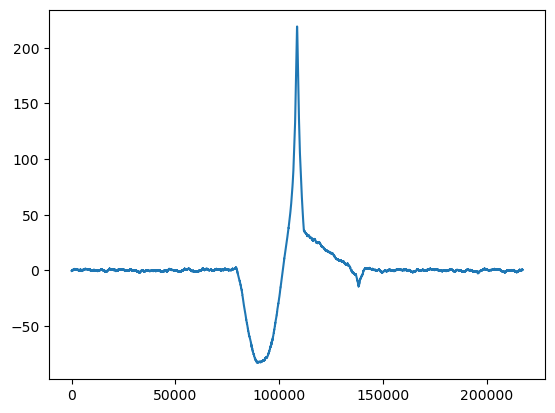

In [4]:
plt.plot(fit_ampl)

In [5]:
template = np.load("/home/dwong/DELight_mtr/trigger_study/wk15/templates/sub_ch_template.npy")
noise_psd = np.load("/home/dwong/DELight_mtr/templates/noise_psd_from_MMC.npy")
fs = 3906250

sub_of = OptimumFilter(template, noise_psd, fs)

In [6]:
a, b, c = sub_of.sliding_fit(example)

In [10]:
index = np.argmax(a)

0.980020708129015


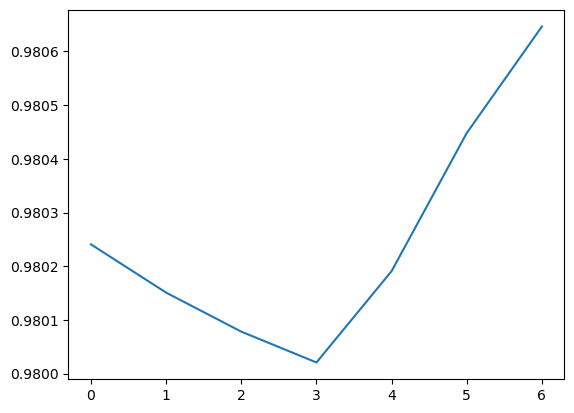

In [21]:
segment = b[index-4:index+3]
print(segment[np.argmin(segment)])
plt.plot(b[index-4:index+3])

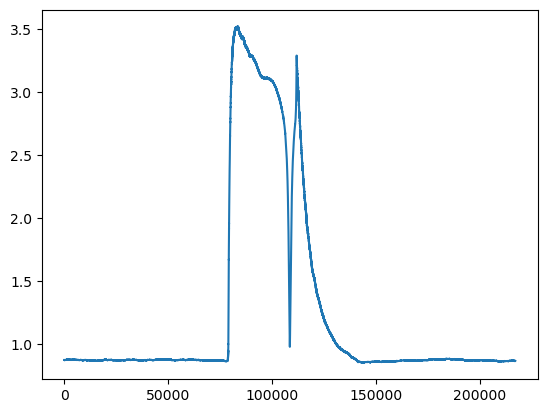

In [22]:
plt.plot(b)

In [16]:
index

108616

In [17]:
idx

108616

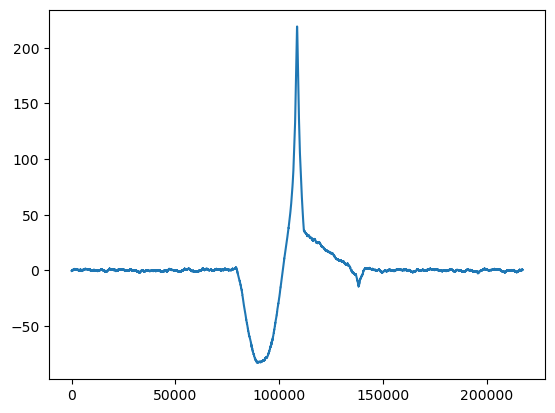

In [7]:
plt.plot(a)

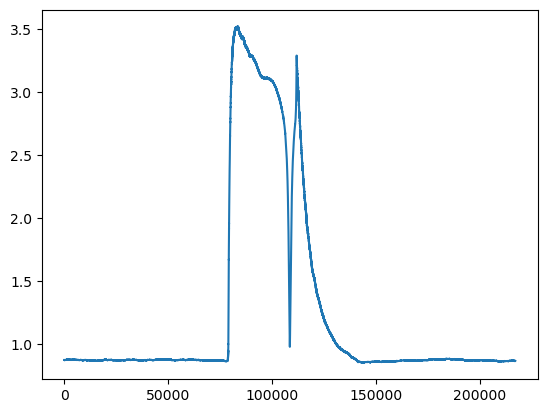

In [8]:
plt.plot(b)

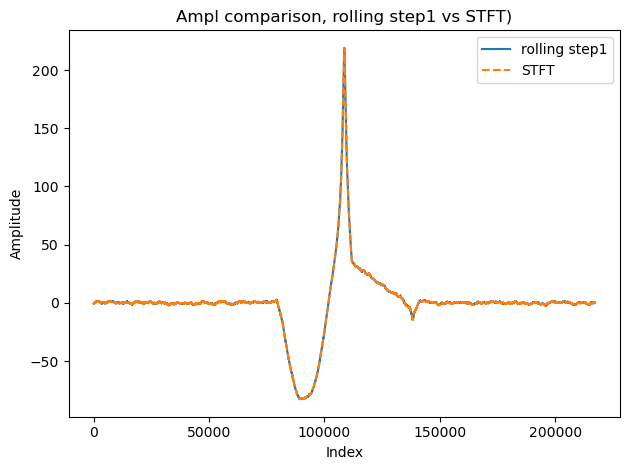

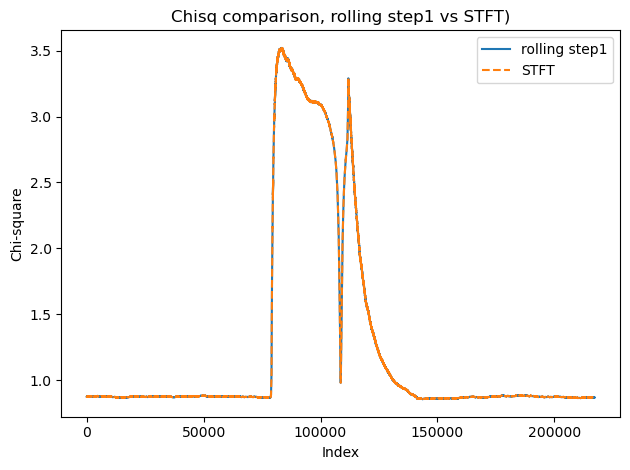

In [9]:
def _metrics(x, y):
        x = np.asarray(x)
        y = np.asarray(y)
        diff = x - y
        max_abs_err = float(np.max(np.abs(diff))) if diff.size else 0.0
        rms_err = float(np.sqrt(np.mean(diff**2))) if diff.size else 0.0
        rel_err_norm = float(np.linalg.norm(diff) / (np.linalg.norm(y) + 1e-15)) if diff.size else 0.0
        corr = float(np.corrcoef(x.ravel(), y.ravel())[0, 1]) if x.size > 1 else float('nan')
        allclose = bool(np.allclose(x, y, rtol=1e-8, atol=1e-12))
        return {
            "allclose": allclose,
            "max_abs_err": max_abs_err,
            "rms_err": rms_err,
            "rel_err_norm": rel_err_norm,
            "corr": corr,
        }

m_ampl = _metrics(a, fit_ampl)
m_chi2 = _metrics(b, fit_chisq)

# Figure 1: amplitude overlay
plt.figure()
plt.plot(a, label="rolling step1")
plt.plot(fit_ampl, label="STFT", linestyle="--")
ttl1 = f"Ampl comparison, rolling step1 vs STFT)"
plt.title(ttl1)
plt.xlabel("Index")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()

# Figure 2: chi-square overlay
plt.figure()
plt.plot(b, label="rolling step1")
plt.plot(fit_chisq, label="STFT", linestyle="--")
ttl2 = f"Chisq comparison, rolling step1 vs STFT)"
plt.title(ttl2)
plt.xlabel("Index")
plt.ylabel("Chi-square")
plt.legend()
plt.tight_layout()
